In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys
import os
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# os.chdir("..")
sys.path.append("src")
sys.path.append("data")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [4]:
from data_pipeline import createValidationData, validateCounts, preprocess, plot_training_history
from evaluation import evaluate_classification, evaluate_roc_auc, save_classification_reports
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [6]:
import os

import os
print(os.getcwd())   # Should print the root directory
print(os.listdir("src"))

# Print the current working directory
print("Current working directory:", os.getcwd())

# Check that 'train/cats' actually exists relative to this directory
print("Folders in current directory:", os.listdir())
print("Folders in 'train':", os.listdir('data/train'))

/Users/anveshradharapu/Documents/Project_Space/ML Engineer/MLEngineerPrep/Pet Breed Classifier
['.DS_Store', 'data_pipeline.py', 'evaluation.py', '__pycache__', '.ipynb_checkpoints']
Current working directory: /Users/anveshradharapu/Documents/Project_Space/ML Engineer/MLEngineerPrep/Pet Breed Classifier
Folders in current directory: ['best_model.h5', '.DS_Store', 'requirements.txt', 'tests', 'models', 'README.md', '.ipynb_checkpoints', 'data', 'outputs', 'notebooks', 'src']
Folders in 'train': ['dogs', 'cats', '.DS_Store']


In [7]:
# createValidationData()

In [8]:
validateCounts()


train data:
  cats: 224 images
  dogs: 223 images

val data:
  cats: 55 images
  dogs: 55 images

test data:
  cats: 70 images
  dogs: 70 images


In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f"data/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'  # or 'categorical' for multi-class
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f"data/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f"data/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

Found 447 files belonging to 2 classes.
Found 110 files belonging to 2 classes.
Found 140 files belonging to 2 classes.


In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),   # rotate images randomly by up to 10%
    layers.RandomZoom(0.1),       # zoom in/out by up to 10%
])

In [11]:
def augment(image, label):
    image = data_augmentation(image)
    return image, label

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(preprocess).map(augment).cache().shuffle(447).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(preprocess).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(preprocess).cache().prefetch(buffer_size=AUTOTUNE)


In [13]:
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)

(32, 128, 128, 3) (32, 1)


In [14]:
def build_tiny_cnn(input_shape=(128,128,3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # binary classification
    ])
    return model

model = build_tiny_cnn()
model.summary()

/Users/anveshradharapu/.pyenv/versions/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    save_best_only=True,
    monitor='val_loss'
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5133 - loss: 0.7287

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.5120 - loss: 0.7279 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.6062 - loss: 0.6897 - val_accuracy: 0.5000 - val_loss: 0.7171
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5511 - loss: 0.6863

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.5524 - loss: 0.6859 - val_accuracy: 0.5545 - val_loss: 0.6885
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.6579 - loss: 0.6409 - val_accuracy: 0.5818 - val_loss: 0.6954
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.7727 - loss: 0.5377 - val_accuracy: 0.5909 - val_loss: 0.7076
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.7309 - loss: 0.5544 - val_accuracy: 0.5727 - val_loss: 0.8856
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.8296 - loss: 0.3908 - val_accuracy: 0.6182 - val_loss: 0.8157
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.8743 - loss: 0.3171 - val_accuracy: 0.6455 - val_loss: 1.0117


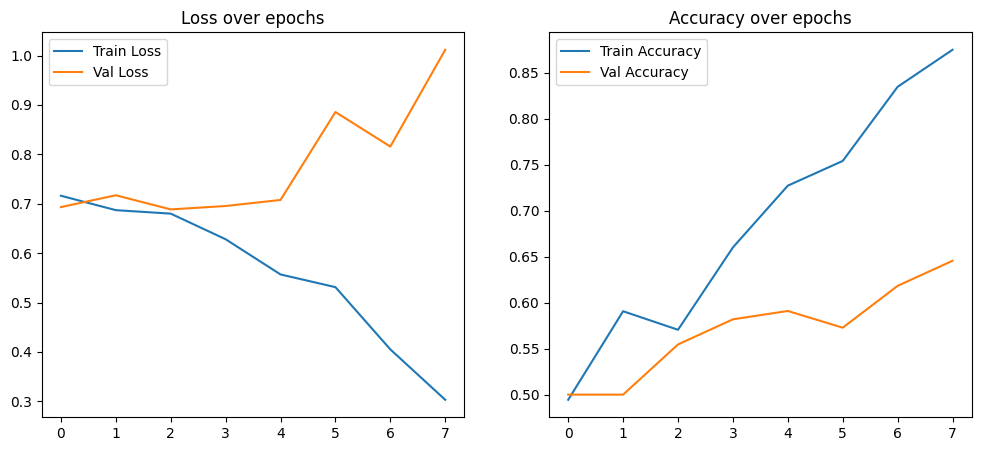

In [16]:
plot_training_history(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


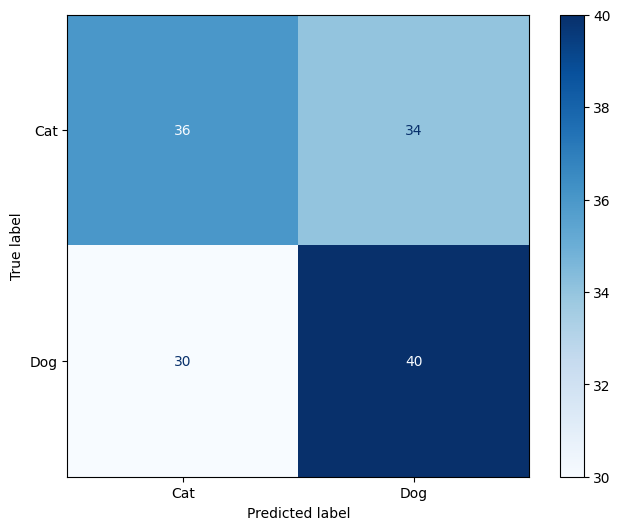

In [17]:
# Get predictions on test set
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])
disp.plot(cmap='Blues',ax=ax)
fig.savefig(os.path.join('outputs', 'confusion_matrix.png'))
plt.show()


In [18]:
metrics = evaluate_classification(y_true, y_pred)
print(metrics)

# Optionally evaluate ROC AUC
roc_score = evaluate_roc_auc(y_true, y_pred_prob)
print("ROC AUC:", roc_score)

# Save report
save_classification_reports(y_true, y_pred)

{'accuracy': 0.5428571428571428, 'precision': 0.542997542997543, 'recall': 0.5428571428571428, 'f1_score': 0.542483660130719}
ROC AUC: 0.5363265306122449
              precision    recall  f1-score   support

         Cat       0.55      0.51      0.53        70
         Dog       0.54      0.57      0.56        70

    accuracy                           0.54       140
   macro avg       0.54      0.54      0.54       140
weighted avg       0.54      0.54      0.54       140

